In [1]:
pip install bambi arviz pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00


#Question 1

In [34]:
#importing libraries
import pandas as pd
import bambi as bmb
import arviz as az

In [35]:
#processing data
df = pd.read_csv("/content/df_powerpose.csv")
df['test_change'] = df['testm2'] - df['testm1']
df['hptreat'] = df['hptreat'].astype('category')
df['hptreat'].cat.set_categories(['Low', 'High'])
df.head()

,Unnamed: 0,id,hptreat,female,age,testm1,testm2,test_change
0,2,29,High,Male,19,38.724998,62.375000,23.650002
1,3,30,Low,Female,20,32.770000,29.235001,-3.534999
2,4,31,High,Female,20,32.320000,27.510000,-4.810000
3,5,32,Low,Female,18,17.995001,28.655001,10.660000
4,7,34,Low,Female,21,73.580002,44.669998,-28.910004


In [36]:
#model
model = bmb.Model("test_change ~ hptreat", data=df,
                  priors={
                      "Intercept": bmb.Prior("Normal", mu=0, sigma=50),
                      "hptreat": bmb.Prior("Normal", mu=0, sigma=20),
                      "sigma": bmb.Prior("HalfStudentT", nu=3, sigma=10)
                  })

results = model.fit(draws=2000, tune=1000)

Output()

In [37]:
az.summary(results, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.02,4.34,-4.16,11.96,0.06,0.07,5012.28,3236.00,1.0
hptreat[Low],-8.06,6.14,-19.54,3.16,0.09,0.11,5089.65,2952.25,1.0
sigma,20.16,2.24,16.24,24.46,0.03,0.04,5073.57,2659.40,1.0


<Axes: title={'center': 'hptreat\nLow'}>

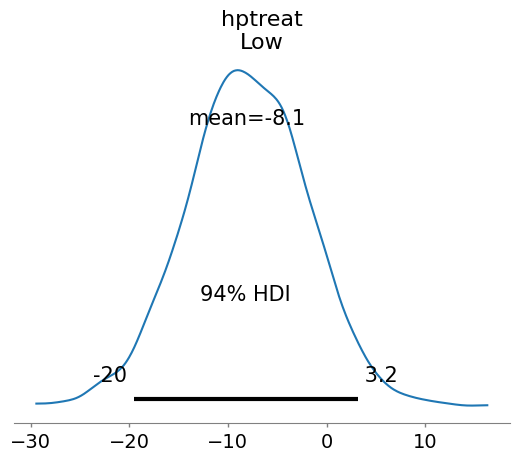

In [38]:
az.plot_posterior(results, var_names=["hptreat"])

#Question 2

In [ ]:
#importing libraries
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.model_selection import KFold

##2.1

In [39]:
def generate_crossings(sentence_length, alpha, beta):
    lambda_ = np.exp(alpha + beta * sentence_length)
    return np.random.poisson(lam=lambda_)

##2.2

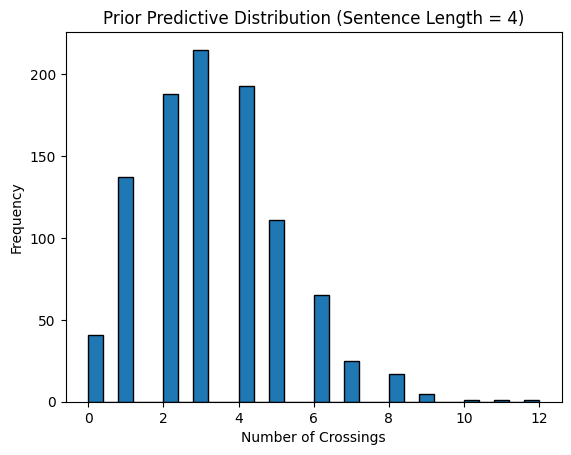

In [41]:
# priors
np.random.seed(42)
alpha_samples = np.random.normal(loc=0.15, scale=0.1, size=1000)
beta_samples = np.random.normal(loc=0.25, scale=0.05, size=1000)

crossing_samples = [generate_crossings(4, a, b) for a, b in zip(alpha_samples, beta_samples)]

plt.hist(crossing_samples, bins=30, edgecolor='k')
plt.title("Prior Predictive Distribution (Sentence Length = 4)")
plt.xlabel("Number of Crossings")
plt.ylabel("Frequency")
plt.show()

In [42]:
#data processing
df = pd.read_csv("/content/crossings.csv")

df["s.length_c"] = df["s.length"] - df["s.length"].mean()
df["lang"] = (df["Language"] == "German").astype(int)

In [43]:
#model 1
def neg_log_likelihood_m1(params, X, y):
    alpha, beta = params
    eta = alpha + beta * X
    lam = np.exp(eta)
    return -np.sum(poisson.logpmf(y, lam))

X1 = df["s.length_c"].values
y = df["nCross"].values

init_params = [0.1, 0.1]
res_m1 = minimize(neg_log_likelihood_m1, init_params, args=(X1, y))
alpha_m1, beta_m1 = res_m1.x
print("M1 estimates:", res_m1.x)

M1 estimates: [0.20031608 0.14938515]


In [44]:
#model2
def neg_log_likelihood_m2(params, X1, X2, X3, y):
    alpha, beta1, beta2, beta3 = params
    eta = alpha + beta1 * X1 + beta2 * X2 + beta3 * (X1 * X2)
    lam = np.exp(eta)
    return -np.sum(poisson.logpmf(y, lam))

X1 = df["s.length_c"].values
X2 = df["lang"].values
y = df["nCross"].values
X3 = X1 * X2

init_params = [0.1, 0.1, 0.1, 0.1]
res_m2 = minimize(neg_log_likelihood_m2, init_params, args=(X1, X2, X3, y))
print("M2 estimates:", res_m2.x)

M2 estimates: [0.16091537 0.09696584 0.02710463 0.09570856]


##2.4

In [46]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
elpd_m1 = 0
elpd_m2 = 0

for train_idx, test_idx in kf.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    # Fit model 1
    res = minimize(neg_log_likelihood_m1, [0.1, 0.1],
                   args=(train["s.length_c"], train["nCross"]))
    alpha1, beta1 = res.x

    # Predictive log-likelihood
    eta_test = alpha1 + beta1 * test["s.length_c"]
    lam_test = np.exp(eta_test)
    elpd_m1 += np.sum(poisson.logpmf(test["nCross"], lam_test))

    # Fit model 2
    res = minimize(neg_log_likelihood_m2, [0.1, 0.1, 0.1, 0.1],
                   args=(train["s.length_c"], train["lang"], train["s.length_c"] * train["lang"], train["nCross"]))
    alpha2, b1, b2, b3 = res.x

    # Predictive log-likelihood
    eta_test = alpha2 + b1 * test["s.length_c"] + b2 * test["lang"] + b3 * test["s.length_c"] * test["lang"]
    lam_test = np.exp(eta_test)
    elpd_m2 += np.sum(poisson.logpmf(test["nCross"], lam_test))

print("Total ELPD (M1):", elpd_m1)
print("Total ELPD (M2):", elpd_m2)
print("Difference (M2 - M1):", elpd_m2 - elpd_m1)

Total ELPD (M1): -2816.1133778511007
Total ELPD (M2): -2682.1600243590037
Difference (M2 - M1): 133.953353492097
